<IPython.core.display.Javascript object>


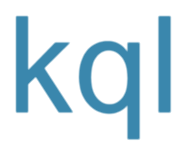

In [20]:
%reload_ext Kqlmagic

In [21]:
%kql AzureDataExplorer://code;cluster='vso';database='vso'

<IPython.core.display.Javascript object>

In [22]:
_Service_ = 'kalypso'
_ScaleUnit_ = 'kalypso-wcus-1'
_AlertTime_ = '2019-09-20 20:45'
_UpperOutlier_ = 5
_LowerOutlier_ = -5
_RunResult_ = 'Succeeded'

In [23]:
dynamic_tsg_transition_scope = ['Succeeded', 'UserError', 'PlatformError']

In [24]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [25]:
printmd("# TSG : Monitor State Transition : {0}".format(_RunResult_))
printmd("## Related Monitors")
printmd("This monitor is fired when kalypso monitor, [Monitor Transition](https://kalypsocus.vstskalypso.visualstudio.com//summary?containerId=5a0432f7-b311-4c7e-810d-3152b0215c8c&selectedPage=summary&monitorId=59787740-e5d6-4740-abdc-df6ef1ec8488), detects an [anomaly](https://kusto.azurewebsites.net/docs/query/series-outliersfunction.html?q=series_outlie), sudden increase of number of monitors failing with Platform error or User error or sudden decrease of number of monitors succeeding, in monitor runs.")

# TSG : Monitor State Transition : Succeeded

## Related Monitors

This monitor is fired when kalypso monitor, [Monitor Transition](https://kalypsocus.vstskalypso.visualstudio.com//summary?containerId=5a0432f7-b311-4c7e-810d-3152b0215c8c&selectedPage=summary&monitorId=59787740-e5d6-4740-abdc-df6ef1ec8488), detects an [anomaly](https://kusto.azurewebsites.net/docs/query/series-outliersfunction.html?q=series_outlie), sudden increase of number of monitors failing with Platform error or User error or sudden decrease of number of monitors succeeding, in monitor runs.

In [26]:
printmd("## Reason for current monitor alert")
printmd("The present monitor run has detected anomaly in number of monitor runs having <span style='color:red;font-weight:bold'>{}</span>".format(_RunResult_))


## Reason for current monitor alert

The present monitor run has detected anomaly in number of monitor runs having <span style='color:red;font-weight:bold'>Succeeded</span>

In [27]:
if _RunResult_ not in dynamic_tsg_transition_scope:
    printmd("Transition type, <b>{}</b>, is not supported in this synamic TSG.".format(_RunResult_))
    

In [28]:
if _RunResult_ == "Succeeded":
    printmd("When this alert fires, usually the <b>UserError state transition</b> monitor and/or the <b>PlatformError state transition</b> monitor also fires an alert.")
    printmd("* If one of these two fired, please refer to the corresponding state transition monitor and STOP HERE (ignore the below analysis)")
    printmd("* Otherwise, continue with the below investigation")

When this alert fires, usually the <b>UserError state transition</b> monitor and/or the <b>PlatformError state transition</b> monitor also fires an alert.

* If one of these two fired, please refer to the corresponding state transition monitor and STOP HERE (ignore the below analysis)

* Otherwise, continue with the below investigation

In [29]:
printmd("In the below figure, outlierPossibility measures the likeliness of failMonitorCount value to be an outlier. The threshold for outlierPossibility is set to {} to {}. This alert is fired because outlier possibility has exceeded or dropped below the threshold value.".format(_UpperOutlier_, _LowerOutlier_))

In the below figure, outlierPossibility measures the likeliness of failMonitorCount value to be an outlier. The threshold for outlierPossibility is set to 5 to -5. This alert is fired because outlier possibility has exceeded or dropped below the threshold value.

In [30]:
%%kql
let _alertTime_ = _AlertTime_;
let endTime = todatetime(_alertTime_);
let _upperOutlier_ = _UpperOutlier_;
let _lowerOutlier_ = _LowerOutlier_;
let _service_ = _Service_;
let _scaleUnit_ = _ScaleUnit_;
let _runResult_ = _RunResult_;
JobHistory
| where TIMESTAMP > bin(endTime - 1d, 5m) and TIMESTAMP <= bin(endTime - 30m, 5m) // take proper time range to avoid spikes around the time boundary
| where Service == _service_
| where ScaleUnit == _scaleUnit_
| where Plugin == "Microsoft.VisualStudio.Services.Kalypso.Jobs.ZeroRowMonitor"
| where ResultMessage contains "Monitor run result" 
| project TIMESTAMP, JobName, Plugin, ResultMessage 
| extend RunResult = case(ResultMessage contains "Monitor run result: Succeeded", "Succeeded",
ResultMessage contains "Monitor run result: SignaledWithError", "SignaledWithError",
ResultMessage contains "Monitor run result: Signaled", "Signaled",
ResultMessage contains "Monitor run result: UserError", "UserError",
ResultMessage contains "Monitor run result: PlatformError", "PlatformError",
"Default")
| where RunResult == _runResult_
| summarize count() by bin(TIMESTAMP, 5m)
| summarize OutlierTimeStamp=makelist(TIMESTAMP, 50000), failMonitorCount = makelist(count_, 50000) 
| extend outlierPossibility=series_outliers(failMonitorCount)
| mvexpand OutlierTimeStamp to typeof(datetime), failMonitorCount to typeof(double), outlierPossibility to typeof(double) limit 50000
| extend Threshold = iff(_runResult_ == "UserError" or _runResult_ == "PlatformError", _upperOutlier_, _lowerOutlier_)
| render timechart with (title = "Number of monitors failing over last 24 hours", ycolumns = failMonitorCount, outlierPossibility, Threshold)

FigureWidget({
    'data': [{'line': {'color': 'rgb(31, 118, 179)', 'width': 1},
              'name': 'failMo…

[{'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 18, 50, tzinfo=tzutc()), 'failMonitorCount': 469.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 19, 5, tzinfo=tzutc()), 'failMonitorCount': 469.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 18, 55, tzinfo=tzutc()), 'failMonitorCount': 453.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 19, 10, tzinfo=tzutc()), 'failMonitorCount': 478.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 5, 25, tzinfo=tzutc()), 'failMonitorCount': 442.0, 'outlierPossibility': -0.1542478779142095, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 5, 30, tzinfo=tzutc()), 'failMonitorCount': 518.0, 'outlierPossibility': 0.0038561969478561144, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 3, 25, tzinfo=tzutc()), 'failMonitorCount': 448.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 3, 15, tzinfo=tzutc()), 'failMonitorCount': 493.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 3, 20, tzinfo=tzutc()), 'failMonitorCount': 477.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 5, 5, tzinfo=tzutc()), 'failMonitorCount': 468.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 5, 10, tzinfo=tzutc()), 'failMonitorCount': 481.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 16, 30, tzinfo=tzutc()), 'failMonitorCount': 506.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 16, 35, tzinfo=tzutc()), 'failMonitorCount': 452.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 16, 10, tzinfo=tzutc()), 'failMonitorCount': 466.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 14, 20, tzinfo=tzutc()), 'failMonitorCount': 472.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 6, 55, tzinfo=tzutc()), 'failMonitorCount': 454.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 8, 10, tzinfo=tzutc()), 'failMonitorCount': 476.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 8, 25, tzinfo=tzutc()), 'failMonitorCount': 447.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 8, 30, tzinfo=tzutc()), 'failMonitorCount': 517.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 7, 55, tzinfo=tzutc()), 'failMonitorCount': 450.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 8, 15, tzinfo=tzutc()), 'failMonitorCount': 495.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 8, 0, tzinfo=tzutc()), 'failMonitorCount': 559.0, 'outlierPossibility': 1.5848969455685036, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 13, 45, tzinfo=tzutc()), 'failMonitorCount': 486.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 13, 50, tzinfo=tzutc()), 'failMonitorCount': 459.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 15, 5, tzinfo=tzutc()), 'failMonitorCount': 464.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 14, 45, tzinfo=tzutc()), 'failMonitorCount': 480.0, 'outlierPossibility': 0.0, 'Threshold': -5},
 {'OutlierTimeStamp': datetime.datetime(2019, 9, 20, 15, 10, tzinfo=t

## Top 5 Exceptions thrown by monitors failing with UserError
ProductTrace table will log the exceptions occurred during monitor execution. Let's examine ProductTrace to get the top exceptions thrown by failing monitors.

In [31]:
%%kql
let _alertTime_ = _AlertTime_;
let endTime = todatetime(_alertTime_);
let _upperOutlier_ = _UpperOutlier_;
let _lowerOutlier_ = _LowerOutlier_;
let _service_ = _Service_;
let _scaleUnit_ = _ScaleUnit_;
let _runResult_ = _RunResult_;
ProductTrace
| where Service == _service_ and ScaleUnit == _scaleUnit_ and ExceptionType != ""
| where TIMESTAMP > endTime - 1h and TIMESTAMP < endTime
| join kind=inner (
    JobHistory
    | where Service == _service_ and ScaleUnit == _scaleUnit_
    | where TIMESTAMP > todatetime(_alertTime_) - 1h
    | where Plugin == "Microsoft.VisualStudio.Services.Kalypso.Jobs.ZeroRowMonitor"
    | where ResultMessage contains "Monitor run result" 
    | project ActivityId, TIMESTAMP, JobName, Plugin, ResultMessage 
    | extend RunResult = case(ResultMessage contains "Monitor run result: Succeeded", "Succeeded",
        ResultMessage contains "Monitor run result: SignaledWithError", "SignaledWithError",
        ResultMessage contains "Monitor run result: Signaled", "Signaled",
        ResultMessage contains "Monitor run result: UserError", "UserError",
        ResultMessage contains "Monitor run result: PlatformError", "PlatformError",
        "Default")
    | where RunResult == _runResult_
) on ActivityId
| project TIMESTAMP, ExceptionType, Message, JobName, ResultMessage
| summarize count() by ExceptionType
| top 5 by count_

ExceptionType,count_
Microsoft.TeamFoundation.Framework.Server.HostShutdownException,3


[{'ExceptionType': 'Microsoft.TeamFoundation.Framework.Server.HostShutdownException', 'count_': 3}]

In [32]:
df_exception = _kql_raw_result_.to_dataframe()
top_5_exception_types = df_exception['ExceptionType'].tolist()
if  "Kusto.Data.Exceptions.KustoClientTimeoutException" in top_5_exception_types or "Kusto.Data.Exceptions.KustoClientException" in top_5_exception_types:
    printmd("Issue is from Kusto side. Check the health of the cluster. If the health of the cluster is bad, raise a ticket againts kusto team")
elif "Kusto.Data.Exceptions.SyntaxException" in top_5_exception_types or "Kusto.Data.Exceptions.KustoBadRequestException" in top_5_exception_types or "Kusto.Data.Exceptions.EntityNotFoundException" in top_5_exception_types:
    printmd("Bad monitors might have been added. Monitors are failing because the trigger query has syntax errors. As a mitigation step, work with monitor owners to disable the monitor and ask them to fix the query.")
elif "Kusto.Data.Exceptions.KustoRequestDeniedException" in top_5_exception_types:
    printmd("The app id used to query data from kusto endpoint doesn't have enough permissions. Work with monitor owner to add kalypso's appId / appId stored in keyvault to kusto cluster")
elif "Kusto.Data.Exceptions.SemanticException" in top_5_exception_types:
    printmd("Top exception thrown is SemanticException. This might be because of user error or access issue. Follow below steps to mitigate the issue.")
else:
    printmd("Unknown exception. Please investigate further and update the dynamic TSG")

Unknown exception. Please investigate further and update the dynamic TSG

In [33]:
printmd("Examine the error message in stack trace.")

Examine the error message in stack trace.

In [34]:
%%kql
let _alertTime_ = _AlertTime_;
let endTime = todatetime(_alertTime_);
let _upperOutlier_ = _UpperOutlier_;
let _lowerOutlier_ = _LowerOutlier_;
let _service_ = _Service_;
let _scaleUnit_ = _ScaleUnit_;
let _runResult_ = _RunResult_;
let _exceptionTypes_ = top_5_exception_types;
ProductTrace
| where Service == _service_ and ScaleUnit == _scaleUnit_ and ExceptionType != ""
| where TIMESTAMP > endTime - 1h and TIMESTAMP < endTime
| join kind=inner (
    JobHistory
    | where Service == _service_ and ScaleUnit == _scaleUnit_
    | where TIMESTAMP > endTime - 1h and TIMESTAMP < endTime
    | where Plugin == "Microsoft.VisualStudio.Services.Kalypso.Jobs.ZeroRowMonitor"
    | where ResultMessage contains "Monitor run result" 
    | project ActivityId, TIMESTAMP, JobName, Plugin, ResultMessage 
    | extend RunResult = case(ResultMessage contains "Monitor run result: Succeeded", "Succeeded",
        ResultMessage contains "Monitor run result: SignaledWithError", "SignaledWithError",
        ResultMessage contains "Monitor run result: Signaled", "Signaled",
        ResultMessage contains "Monitor run result: UserError", "UserError",
        ResultMessage contains "Monitor run result: PlatformError", "PlatformError",
        "Default")
    | where RunResult == _runResult_
) on ActivityId
| project TIMESTAMP, ExceptionType, Message, JobName, ResultMessage
| where ExceptionType in (_exceptionTypes_)
| limit 10

[{'TIMESTAMP': datetime.datetime(2019, 9, 20, 19, 56, 54, 829144, tzinfo=tzutc()), 'ExceptionType': 'Microsoft.TeamFoundation.Framework.Server.HostShutdownException', 'Message': 'Microsoft.TeamFoundation.Framework.Server.HostShutdownException: VS403201: The organization is currently offline as it is being moved to another enterprise. Once the move has been completed the organization will come back online. Try accessing the organization at a later time. Activity Id: 7b36f2c8-498a-4dcd-a474-d4ff478bf08c.\r\n   at Microsoft.VisualStudio.Services.WebApi.VssHttpClientBase.<HandleResponseAsync>d__53.MoveNext() in D:\\v2.0\\P1\\_work\\7\\s\\Vssf\\Client\\WebApi\\VssHttpClientBase.cs:line 935\r\n--- End of stack trace from previous location where exception was thrown ---\r\n   at System.Runtime.ExceptionServices.ExceptionDispatchInfo.Throw()\r\n   at System.Runtime.CompilerServices.TaskAwaiter.HandleNonSuccessAndDebuggerNotification(Task task)\r\n   at Microsoft.VisualStudio.Services.WebApi.VssHttpClientBase.<SendAsync>d__51.MoveNext() in D:\\v2.0\\P1\\_work\\7\\s\\Vssf\\Client\\WebApi\\VssHttpClientBase.cs:line 883\r\n--- End of stack trace from previous location where exception was thrown ---\r\n   at System.Runtime.ExceptionServices.ExceptionDispatchInfo.Throw()\r\n   at System.Runtime.CompilerServices.TaskAwaiter.HandleNonSuccessAndDebuggerNotification(Task task)\r\n   at Microsoft.VisualStudio.Services.WebApi.VssHttpClientBase.<SendAsync>d__47`1.MoveNext() in D:\\v2.0\\P1\\_work\\7\\s\\Vssf\\Client\\WebApi\\VssHttpClientBase.cs:line 755\r\n--- End of stack trace from previous location where exception was thrown ---\r\n   at System.Runtime.ExceptionServices.ExceptionDispatchInfo.Throw()\r\n   at System.Runtime.CompilerServices.TaskAwaiter.HandleNonSuccessAndDebuggerNotification(Task task)\r\n   at Microsoft.VisualStudio.Services.Location.Client.LocationHttpClient.<GetConnectionDataAsync>d__6.MoveNext() in D:\\v2.0\\P1\\_work\\7\\s\\Vssf\\Client\\WebApi\\HttpClients\\LocationHttpClient.cs:line 73\r\n--- End of stack trace from previous location where exception was thrown ---\r\n   at System.Runtime.ExceptionServices.ExceptionDispatchInfo.Throw()\r\n   at System.Runtime.CompilerServices.TaskAwaiter.HandleNonSuccessAndDebuggerNotification(Task task)\r\n   at Microsoft.VisualStudio.Services.Location.Server.RemoteLocationDataProvider.FetchLocationData(IVssRequestContext requestContext) in D:\\v2.0\\P1\\_work\\7\\s\\Vssf\\Sdk\\Server\\Location\\RemoteLocationDataProvider.cs:line 297\r\n   at Microsoft.VisualStudio.Services.Location.Server.LocationDataProvider.<GetLocationData>b__43_0(IVssRequestContext request, String key) in D:\\v2.0\\P1\\_work\\7\\s\\Vssf\\Sdk\\Server\\Location\\LocationDataProvider.cs:line 1395\r\n   at Microsoft.VisualStudio.Services.Location.Server.LocationDataCache`1.GetLocationData(IVssRequestContext requestContext, T cacheKeyIdentifier, Func`3 loadData) in D:\\v2.0\\P1\\_work\\7\\s\\Vssf\\Sdk\\Server\\Location\\LocationCache.cs:line 152\r\n   at Microsoft.VisualStudio.Services.Location.Server.LocationDataProvider.GetLocationData(IVssRequestContext requestContext) in D:\\v2.0\\P1\\_work\\7\\s\\Vssf\\Sdk\\Server\\Location\\LocationDataProvider.cs:line 1382\r\n   at Microsoft.VisualStudio.Services.Location.Server.RemoteLocationDataProvider..ctor(IVssRequestContext requestContext, ILocationDataCache`1 locationCache, String remoteLocationUrl) in D:\\v2.0\\P1\\_work\\7\\s\\Vssf\\Sdk\\Server\\Location\\RemoteLocationDataProvider.cs:line 41\r\n   at Microsoft.VisualStudio.Services.Location.Server.LocationService.CreateRemoteDataProvider(IVssRequestContext requestContext, String location) in D:\\v2.0\\P1\\_work\\7\\s\\Vssf\\Sdk\\Server\\Location\\LocationService.cs:line 404\r\n   at Microsoft.VisualStudio.Services.Location.Server.LocationService.ResolveLocationData(IVssRequestContext requestContext, Guid serviceAreaIdentifier) in D:\\v2.0\\P1\\_work\\7\\s\\Vssf\\Sdk\\Server\\Location\\LocationService.cs:line 312\r\n   at

In [35]:
if "Kusto.Data.Exceptions.SemanticException" in top_5_exception_types:
    printmd('if message is of format "Principal xxxxxx is not authorized to access database dbxxxxx.", add principle ID mentioned to the database or report the issue to Kalyso V-Team at kalypsovt@microsoft.com')

### Distribution of exceptions
To understand the severity of the issue let's see number of monitors and containers that are being affected

In [36]:
%%kql
let _alertTime_ = _AlertTime_;
let endTime = todatetime(_alertTime_);
let _upperOutlier_ = _UpperOutlier_;
let _lowerOutlier_ = _LowerOutlier_;
let _service_ = _Service_;
let _scaleUnit_ = _ScaleUnit_;
let _runResult_ = _RunResult_;
JobHistory
| where TIMESTAMP > bin(endTime - 1h, 5m) and TIMESTAMP <= bin(endTime - 30m, 5m) // take proper time range to avoid spikes around the time boundary
| where Service == _service_
| where ScaleUnit == _scaleUnit_
| where Plugin == "Microsoft.VisualStudio.Services.Kalypso.Jobs.ZeroRowMonitor"
| where ResultMessage contains "Monitor run result" 
| project TIMESTAMP, JobName, Plugin, ResultMessage 
| extend RunResult = case(ResultMessage contains "Monitor run result: UserError", "UserError",
ResultMessage contains "Monitor run result: PlatformError", "PlatformError",
"Default")
| where RunResult == _runResult_
| parse kind=regex ResultMessage with "Running ZeroRowMonitor: "monitor_name". container: "container_name
| summarize by monitor_name, container_name
| summarize NumberOfImpactedMonitors = dcount(monitor_name), NumberOfImpactedContainers = dcount(container_name)

NumberOfImpactedMonitors,NumberOfImpactedContainers
0,0


[{'NumberOfImpactedMonitors': 0, 'NumberOfImpactedContainers': 0}]